In [1]:
import pandas as pd
import numpy as np

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
MUMBAI_GEO_OBJ = pickle.load(open("./mumbai_geodata.pkl", "rb"))
MUMBAI_MASK = MUMBAI_GEO_OBJ['mumbai_mask']
MUMBAI_COORDS = MUMBAI_GEO_OBJ['mumbai_coords']

DECIMAL_PLACES = 7
PROCESS_ML_DATA = True

In [3]:
india_stations_df = pd.read_pickle('../2015-2020-pm25/india_stations.pkl')

mcd19a2_obj = pickle.load(open("./mcd19a2.pkl", "rb"))
mcd19a2_longitude, mcd19a2_latitude = mcd19a2_obj['longitude'], mcd19a2_obj['latitude']

In [4]:
def get_nearest_point_idx(latitude, longitude, user_lat, user_lon):
        
    R = 6371000
    lat1 = np.radians(user_lat)
    lat2 = np.radians(latitude)
    delta_lat = np.radians(latitude-user_lat)
    delta_lon = np.radians(longitude-user_lon)
    a = (np.sin(delta_lat/2))*(np.sin(delta_lat/2))+(np.cos(lat1))*(np.cos(lat2))*(np.sin(delta_lon/2))*(np.sin(delta_lon/2))
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R*c
    
    x, y = np.unravel_index(d.argmin(),d.shape)
    
    return x, y

In [5]:
def get_station_names(station_id):   
    df_row = india_stations_df[india_stations_df['StationId'] == station_id]
    name, city, station_lat, station_lon = df_row.values[0][0], df_row.values[0][2], df_row.values[0][3], df_row.values[0][4]

    print("="*50)
    print(f"Name: {name}")
    print(f"City: {city}")
    print(f"Coordinates: ({station_lat}, {station_lon})")
    print("="*50)
    
    return name, city, station_lat, station_lon

In [6]:
def get_nearest_3x3_grid(data, x, y):
    
    if x < 1:
        x += 1
    if x > data.shape[0]-2:
        x -= 2
    if y < 1:
        y += 1
    if y > data.shape[1]-2:
        y -= 2  
    
    three_by_three = data[x-1:x+2,y-1:y+2]
    three_by_three = three_by_three.astype(float)
    
    not_nans = np.count_nonzero(~np.isnan(three_by_three))
    
    if not_nans == 0:
        return {
            "x": x,
            "y": y,
        }
    else:
        three_by_three_average = np.nanmean(three_by_three)
        three_by_three_std = np.nanstd(three_by_three)
        three_by_three_median = np.nanmedian(three_by_three)
        
        return {
            "x": x,
            "y": y,
            "data": three_by_three,
            "average": three_by_three_average,
            "std": three_by_three_std,
            "median": three_by_three_median
        }    

In [7]:
def nearest_lat_lon(station_lat, station_lon):
    x, y = get_nearest_point_idx(mcd19a2_latitude, mcd19a2_longitude, station_lat, station_lon)
    nearest_lon, nearest_lat = np.round(mcd19a2_longitude[x,y], 8), np.round(mcd19a2_latitude[x,y], 8)

    print("="*50)
    print(f"Nearest Coordinates: ({nearest_lat}, {nearest_lon})")
    print("="*50)
    
    return x, y, nearest_lat, nearest_lon

In [8]:
station_id = "MH012"
name, city, station_lat, station_lon = get_station_names(station_id)
x_coord, y_coord, nearest_lat, nearest_lon = nearest_lat_lon(station_lat, station_lon)

Name: Vasai West, Mumbai - MPCB
City: Mumbai
Coordinates: (19.3301045, 72.8149705)
Nearest Coordinates: (19.33277731, 72.8142447)


In [9]:
import glob

PATH = "../Downloads/Mumbai-Nov-2019/hdfs/*.hdf"
FILE_LIST = glob.glob(PATH)

In [10]:
import multiprocessing as mp
from pyhdf import SD
import pickle

manager = mp.Manager()
total_ml_data = manager.list()

fix_station_lat, fix_station_lon = nearest_lat, nearest_lon 

def extract_aod_values_from_hdf(idx):

    SDS_NAME = "Optical_Depth_047"
    FILE_NAME = FILE_LIST[idx]
    hdf = SD.SD(FILE_NAME)
    sds = hdf.select(SDS_NAME)

    NAME = FILE_NAME.split('/')[-1]

    data = sds.get()

    attributes = sds.attributes()
    scale_factor = attributes['scale_factor']
    fv = attributes['_FillValue']

    data = data.astype(float)
    data[data == fv] = np.nan
    data = np.nanmean(data, axis=0)

    scaled_data = data * scale_factor
    
    try:
        fix_station_aod = get_nearest_3x3_grid(scaled_data, x_coord, y_coord)['average'].round(3)
    except Exception as e:
        return

    aod_data = np.array(list(zip(scaled_data[MUMBAI_MASK], mcd19a2_latitude[MUMBAI_MASK], mcd19a2_longitude[MUMBAI_MASK])))
    df_aod = pd.DataFrame(aod_data, columns=['aod_value', 'latitude', 'longitude'])
    df_aod = df_aod.dropna().reset_index(drop=True).round(DECIMAL_PLACES)
    
    data = np.array(list(zip([fix_station_aod for k in range(df_aod.shape[0])], 
                             ((fix_station_lat - df_aod['latitude']).values), 
                             ((fix_station_lon - df_aod['longitude']).values), 
                             df_aod['aod_value'].values)
                        ))
    
    total_ml_data.append(data)

In [11]:
if PROCESS_ML_DATA:
    pool = mp.Pool(mp.cpu_count())
    pool.map(extract_aod_values_from_hdf, [idx for idx in range(len(FILE_LIST))])
    pool.close()
    
    total_data = np.vstack([data for data in total_ml_data])
    np.random.shuffle(total_data)
    pickle.dump(total_data, open("total_data_ml.pkl", "wb"), protocol=4)
else:
    total_data = pickle.load(open("total_data_ml.pkl", "rb"))

In [12]:
total_data

array([[ 0.407     ,  0.17514591, -0.0339676 ,  0.3625    ],
       [ 0.442     ,  0.36697251, -0.0113225 ,  0.416     ],
       [ 0.116     ,  0.21684741, -0.1245477 ,  0.121     ],
       ...,
       [ 0.11      ,  0.17514591, -0.0679351 ,  0.107     ],
       [ 0.407     ,  0.26688911, -0.1245477 ,  0.314     ],
       [ 0.436     ,  0.12510421, -0.1019027 ,  0.431     ]])

In [13]:
total_data.shape

(2465, 4)

In [14]:
SIZE_LIMIT = int(2.5e4)

if total_data.shape[0] > SIZE_LIMIT:
    total_data = total_data[np.random.choice(total_data.shape[0], int(SIZE_LIMIT), replace=False), :]

In [15]:
total_data.shape

(2465, 4)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [17]:
X = total_data[:,:-1]
y = total_data[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def get_polynomial_reg_model(n = 4):
    
    poly_reg = PolynomialFeatures(degree = n)
    X_poly = poly_reg.fit_transform(X_train)

    regressor = LinearRegression(n_jobs=-1)
    regressor.fit(X_poly, y_train)

    y_pred = regressor.predict(poly_reg.transform(X_test))
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return regressor, score, poly_reg

def get_linear_reg_model():
    
    regressor = LinearRegression(n_jobs=-1)
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return regressor, score, None

def get_decision_tree_reg_model():
    
    regressor = DecisionTreeRegressor(random_state=42)
    regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return regressor, score, None

def get_random_forrest_reg_model():
    
    regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return regressor, score, None

def get_svr_reg_model():
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_sc = sc_X.fit_transform(X_train)
    y_train_sc = sc_y.fit_transform(y_train)
    
    regressor = SVR(kernel='rbf')
    regressor.fit(X_train_sc, y_train_sc)
    
    y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))
    score = {
        "r2_score": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred), 
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "mean": np.mean(y_test)
    }
    
    return regressor, score, (sc_X, sc_y)

In [19]:
MODEL_LIST = [
    ('Polynomial', get_polynomial_reg_model),
    ('Linear', get_linear_reg_model),
    ('Decision Tree', get_decision_tree_reg_model),
    ('Random Forrest', get_random_forrest_reg_model),
    ('SVR', get_svr_reg_model)
]

In [20]:
best = {}
best_score = 9e9

rows = []

for name, model_fn in MODEL_LIST:
    regressor, score, scaler = model_fn()
    row = [f"{name} Regression", score['mae'], score['rmse'], score['r2_score'], score['mean']]
    rows.append(row)
    
    if score['rmse'] < best_score:
        best['name'] = name + " Regression"
        best['regressor'] = regressor
        best['scaler'] = scaler
        best['score'] = score        
        best_score = score['rmse']

model_dfs = pd.DataFrame(rows, columns=["model", "mae", "rmse", "r2_score", "mean"])
model_dfs

,model,mae,rmse,r2_score,mean
0,Polynomial Regression,0.026019,0.039132,0.936684,0.253337
1,Linear Regression,0.030462,0.048063,0.904489,0.253337
2,Decision Tree Regression,0.011133,0.027088,0.969663,0.253337
3,Random Forrest Regression,0.011060,0.024133,0.975919,0.253337
4,SVR Regression,0.026773,0.044592,0.917785,0.253337


In [21]:
pickle.dump(best, open(f"spt_models/{station_id}_spt.pkl", "wb"), protocol=4)

In [22]:
regressor = best['regressor']
scaler = best['scaler']

def model_predict(X):    
    if scaler:
        try:
            sc_X, sc_y = scaler
            y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X)))
        except Exception as e:
            poly_reg = scaler
            y_pred = regressor.predict(poly_reg.transform(X))
    else:
        y_pred = regressor.predict(X)
    return y_pred

In [23]:
idx = 1

FILE_NAME = FILE_LIST[idx]
NAME = FILE_NAME.split('/')[-1]
SDS_NAME = "Optical_Depth_047"

import datetime

def extract_date_from_file_name(FILE_NAME):
    return datetime.datetime.strptime(FILE_NAME.split('/')[-1].split('.')[1:][0][1:], "%Y%j")

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm

pkl_obj = pickle.load(open("mumbai_geodata.pkl", "rb"))
MUMBAI_B_MIN_LON, MUMBAI_B_MAX_LON = pkl_obj['min_lon'], pkl_obj['max_lon']
MUMBAI_B_MIN_LAT, MUMBAI_B_MAX_LAT = pkl_obj['min_lat'], pkl_obj['max_lat']
boundary = pkl_obj['boundary']
mask = pkl_obj['mumbai_mask'] 
date_time = extract_date_from_file_name(FILE_NAME)

def plot_mumbai_aod_map(scaled_data, save=False, should_mask=True):

    add_text = ""
    
    plt.figure(figsize=(20, 10))

    pad = 0.01

    m = Basemap(projection='cyl', resolution='l', llcrnrlat=MUMBAI_B_MIN_LAT-pad, urcrnrlat=MUMBAI_B_MAX_LAT+pad, llcrnrlon=MUMBAI_B_MIN_LON-pad, urcrnrlon=MUMBAI_B_MAX_LON+pad , suppress_ticks=True)

    m.readshapefile("../Municipal_Spatial_Data/Mumbai/Mumbai",'Mumbai', linewidth=1)

    m.drawparallels(np.arange(-90., 120., 0.05), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 0.05), labels=[0, 0, 0, 1])
    x, y = m(mcd19a2_longitude[mask], mcd19a2_latitude[mask])

    if should_mask:
        sc = m.scatter(x, y, c=scaled_data[mask], s=250, cmap=plt.cm.jet,
                        edgecolors='white', linewidth=0, marker='s')
    else:
        add_text = "_interpolated"
        sc = m.scatter(x, y, c=scaled_data, s=250, cmap=plt.cm.jet,
                        edgecolors='white', linewidth=0, marker='s')

#     plt.clim(0, 2)

    cb = m.colorbar()
    cb.set_label('AOD')

    plotTitle = NAME[:-4]
    plt.title('{0}\n {1}\n Mumbai, India\n {2}'.format(plotTitle, SDS_NAME, date_time.strftime("%Y-%m-%d")))
    fig = plt.gcf()

    plt.show()
    
    if save:
        pngfile = 'images/{0}{1}.png'.format(plotTitle, add_text)
        fig.savefig(pngfile, bbox_inches="tight", dpi=400)

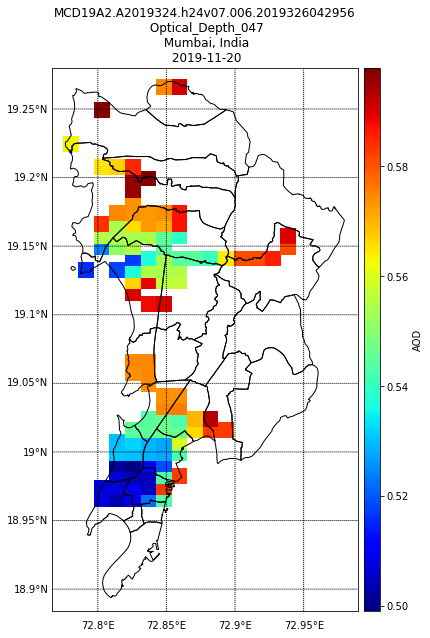

In [24]:
hdf = SD.SD(FILE_NAME)
sds = hdf.select(SDS_NAME)
data = sds.get()

attributes = sds.attributes()
scale_factor = attributes['scale_factor']
fv = attributes['_FillValue']

data = data.astype(float)
data[data == fv] = np.nan
data = np.nanmean(data, axis=0)

scaled_data = data * scale_factor

plot_mumbai_aod_map(scaled_data, save=True)

In [25]:
fix_station_aod = get_nearest_3x3_grid(scaled_data, x_coord, y_coord)['average'].round(3)

In [26]:
X_sp_interpolate_sub = np.array(list(zip([fix_station_aod for k in range(MUMBAI_COORDS.shape[0])],
                         (fix_station_lat - MUMBAI_COORDS[:,0]),
                         (fix_station_lon - MUMBAI_COORDS[:,1]),
                        )
                    ))
y_sp_interpolate_sub = model_predict(X_sp_interpolate_sub).reshape(-1,1)
y_sp_interpolate = y_sp_interpolate_sub

In [27]:
X_sp_interpolate_sub

array([[ 4.63000000e-01,  4.33694741e-01, -3.91993638e-09],
       [ 4.63000000e-01,  4.25354458e-01, -3.91993638e-09],
       [ 4.63000000e-01,  4.17014174e-01, -3.91993638e-09],
       ...,
       [ 4.63000000e-01,  7.50625477e-02, -5.66125977e-02],
       [ 4.63000000e-01,  6.67222641e-02, -3.39675602e-02],
       [ 4.63000000e-01,  6.67222641e-02, -4.52900790e-02]])

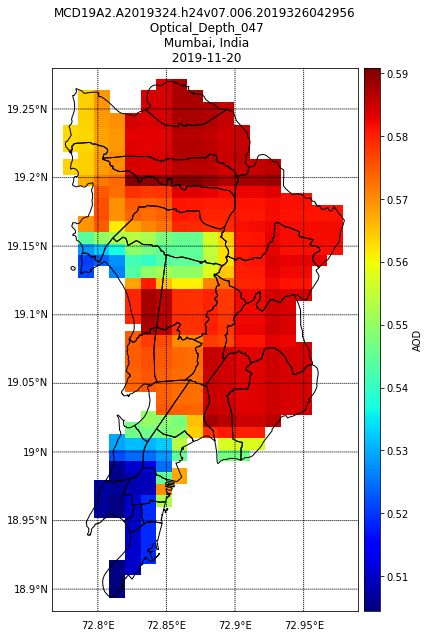

In [28]:
plot_mumbai_aod_map(y_sp_interpolate, save=True, should_mask=False)